# NB07 — Inference & Qualitative Selection

**Goal**: Transform raw importance scores from both the BiLSTM and Transformer into binary summaries and visualize their decision-making process.

### Key Features:
1. **Synced Architectures**: Matches the exact hyperparameters from NB05 v4 (Compact BiLSTM) and NB06 v2 (Interpretable Transformer).
2. **Top-15% Budget Selection**: Standard strategy for TVSum to convert continuous scores to binary summaries.
3. **Attention Visualization**: Heatmaps showing where the Transformer is "looking" globally across the video.
4. **Comparative Plots**: Side-by-side view of Sequential (BiLSTM) vs Global (Transformer) decision profiles.

In [6]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import math

# Environment Setup
IS_KAGGLE = Path("/kaggle/input").exists()
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if IS_KAGGLE:
    FEATURES_PATH = Path("/kaggle/input/tvsum-features/tvsum_features.npy")
    INDEX_PATH = Path("/kaggle/input/tvsum-frame-index/tvsum_frame_index.parquet")
    TARGETS_PATH = Path("/kaggle/input/tvsum-targets/tvsum_targets.parquet")
    VAL_SPLIT_PATH = Path("/kaggle/input/tvsum-val/tvsum_val.txt")
    BILSTM_PATH = Path("/kaggle/input/tvsum-bilstm-v1/tvsum_bilstm_v1.pth")
    TRANSFORMER_PATH = Path("/kaggle/input/tvsum-transformer-v1/tvsum_transformer_v1.pth")
    PLOT_DIR = Path("/kaggle/working/")
else:
    FEATURES_PATH = Path("data/processed/tvsum_features.npy")
    INDEX_PATH = Path("data/processed/tvsum_frame_index.parquet")
    TARGETS_PATH = Path("data/processed/tvsum_targets.parquet")
    VAL_SPLIT_PATH = Path("data/processed/splits/tvsum_val.txt")
    BILSTM_PATH = Path("models/tvsum_bilstm_v4.pth") # Locally keep v4 name
    TRANSFORMER_PATH = Path("models/tvsum_transformer_v2.pth") # Locally keep v2 name
    PLOT_DIR = Path("reports/plots")

PLOT_DIR.mkdir(parents=True, exist_ok=True)
print(f"Device: {DEVICE}")

Device: cuda


## 1. Architecture Definitions

Ensuring models are defined exactly as they were during training in NB05 and NB06.

In [7]:
class CompactBiLSTM(nn.Module):
    def __init__(self, input_dim=960, bottleneck_dim=256, hidden_dim=128):
        super().__init__()
        self.projection = nn.Sequential(
            nn.Linear(input_dim, bottleneck_dim),
            nn.LayerNorm(bottleneck_dim),
            nn.ReLU(),
            nn.Dropout(0.3)
        )
        self.lstm = nn.LSTM(bottleneck_dim, hidden_dim, num_layers=1, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_dim * 2, 1)
    def forward(self, x):
        x = self.projection(x)
        out, _ = self.lstm(x)
        return self.fc(out)

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)
    def forward(self, x):
        return x + self.pe[:x.size(1), :]

class InterpretableTransformerLayer(nn.Module):
    def __init__(self, d_model, nhead, dim_feedforward=512, dropout=0.3):
        super().__init__()
        self.self_attn = nn.MultiheadAttention(d_model, nhead, dropout=dropout, batch_first=True)
        self.linear1 = nn.Linear(d_model, dim_feedforward)
        self.dropout = nn.Dropout(dropout)
        self.linear2 = nn.Linear(dim_feedforward, d_model)
        self.norm1, self.norm2 = nn.LayerNorm(d_model), nn.LayerNorm(d_model)
        self.dropout1, self.dropout2 = nn.Dropout(dropout), nn.Dropout(dropout)
    def forward(self, src):
        src2, attn_weights = self.self_attn(src, src, src, need_weights=True)
        src = self.norm1(src + self.dropout1(src2))
        src2 = self.linear2(self.dropout(torch.relu(self.linear1(src))))
        src = self.norm2(src + self.dropout2(src2))
        return src, attn_weights

class TransformerSummarizerV2(nn.Module):
    def __init__(self, input_dim=960, d_model=256, nhead=4, num_layers=3):
        super().__init__()
        self.project = nn.Sequential(nn.Linear(input_dim, d_model), nn.LayerNorm(d_model), nn.ReLU(), nn.Dropout(0.3))
        self.pos_enc = PositionalEncoding(d_model)
        self.layers = nn.ModuleList([InterpretableTransformerLayer(d_model, nhead) for _ in range(num_layers)])
        self.head = nn.Linear(d_model, 1)
    def forward(self, x, return_attn=False):
        x = self.pos_enc(self.project(x))
        all_attn = []
        for layer in self.layers:
            x, attn = layer(x)
            if return_attn: all_attn.append(attn)
        out = self.head(x)
        return (out, all_attn) if return_attn else out

## 2. Load Weights & Data

In [8]:
# Load data
features = np.load(FEATURES_PATH)
index_df = pd.read_parquet(INDEX_PATH)
targets_df = pd.read_parquet(TARGETS_PATH)
with open(VAL_SPLIT_PATH, 'r') as f: val_ids = [l.strip() for l in f if l.strip()]

# Load models
bilstm = CompactBiLSTM().to(DEVICE)
bilstm.load_state_dict(torch.load(BILSTM_PATH, map_location=DEVICE))
bilstm.eval()

transformer = TransformerSummarizerV2().to(DEVICE)
transformer.load_state_dict(torch.load(TRANSFORMER_PATH, map_location=DEVICE))
transformer.eval()

print(f"Weights loaded from: {BILSTM_PATH} and {TRANSFORMER_PATH}")

Weights loaded from: /kaggle/input/tvsum-bilstm-v1/tvsum_bilstm_v1.pth and /kaggle/input/tvsum-transformer-v1/tvsum_transformer_v1.pth


## 3. Utilities for Selection & Prediction

In [9]:
def get_video_features(vid_id):
    rows = index_df[index_df['video_id'] == vid_id].index
    x = torch.FloatTensor(features[rows]).unsqueeze(0).to(DEVICE)
    y = targets_df.iloc[rows]['importance_score'].values
    return x, y

def select_top_k(scores, budget=0.15):
    """Binary summary mask based on a percentage duration budget."""
    n_frames = len(scores)
    k = max(1, int(n_frames * budget))
    top_indices = np.argsort(scores)[-k:]
    mask = np.zeros(n_frames)
    mask[top_indices] = 1
    return mask

def run_prediction(vid_id):
    x, y_gt = get_video_features(vid_id)
    with torch.no_grad():
        p_bi = torch.clamp(bilstm(x), 0, 1).cpu().squeeze().numpy()
        p_tr, attn = transformer(x, return_attn=True)
        p_tr = torch.clamp(p_tr, 0, 1).cpu().squeeze().numpy()
    return y_gt, p_bi, p_tr, attn

## 4. Qualitative Visualization Pipeline

We use a multi-row layout to compare models:
1. **Raw Predictions**: Continuous curves against Ground Truth (GT).
2. **Selection Strips**: Binary summaries showing the 15% budget keyframes.
3. **Attention Map**: Interpreting why the Transformer made its specific choices.

In [10]:
def visualize_summary(vid_id):
    y_gt, p_bi, p_tr, attn_maps = run_prediction(vid_id)
    sum_bi = select_top_k(p_bi)
    sum_tr = select_top_k(p_tr)

    fig, axes = plt.subplots(4, 1, figsize=(15, 12), gridspec_kw={'height_ratios': [2, 0.5, 0.5, 1]})
    fig.suptitle(f"Video Analysis: {vid_id}\nBlue = BiLSTM (Sequential Bias) | Red = Transformer (Global Bias)", fontsize=16)

    # Row 1: Curves
    axes[0].plot(y_gt, color='gray', alpha=0.3, label='Ground Truth', linewidth=2)
    axes[0].plot(p_bi, color='blue', label='BiLSTM', alpha=0.8)
    axes[0].plot(p_tr, color='red', label='Transformer', alpha=0.8)
    axes[0].set_title("Importance Level Predicted Curves")
    axes[0].legend(loc='upper right')

    # Row 2: BiLSTM Selections
    axes[1].imshow(sum_bi.reshape(1, -1), aspect='auto', cmap='Blues', interpolation='nearest')
    axes[1].set_ylabel("BiLSTM")
    axes[1].set_yticks([])
    axes[1].set_title("Selected Keyframe Masks (15% Budget)")

    # Row 3: Transformer Selections
    axes[2].imshow(sum_tr.reshape(1, -1), aspect='auto', cmap='Reds', interpolation='nearest')
    axes[2].set_ylabel("Transformer")
    axes[2].set_yticks([])

    # Row 4: Transformer Attention (Last Layer)
    last_attn = attn_maps[-1].cpu().squeeze().numpy() 
    im = axes[3].imshow(last_attn, aspect='auto', cmap='magma')
    axes[3].set_title("Transformer Self-Attention Heatmap (Last Layer)")
    axes[3].set_ylabel("Query Frame")
    axes[3].set_xlabel("Attended Frame")
    fig.colorbar(im, ax=axes[3], orientation='vertical', pad=0.01)

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    save_path = PLOT_DIR / f"{vid_id}_qualitative.png"
    plt.savefig(save_path)
    plt.show()
    print(f"Saved qualitative plot to: {save_path}")

## 5. Generate Qualitative Report

Visualizing the top 3 videos from the validation set.

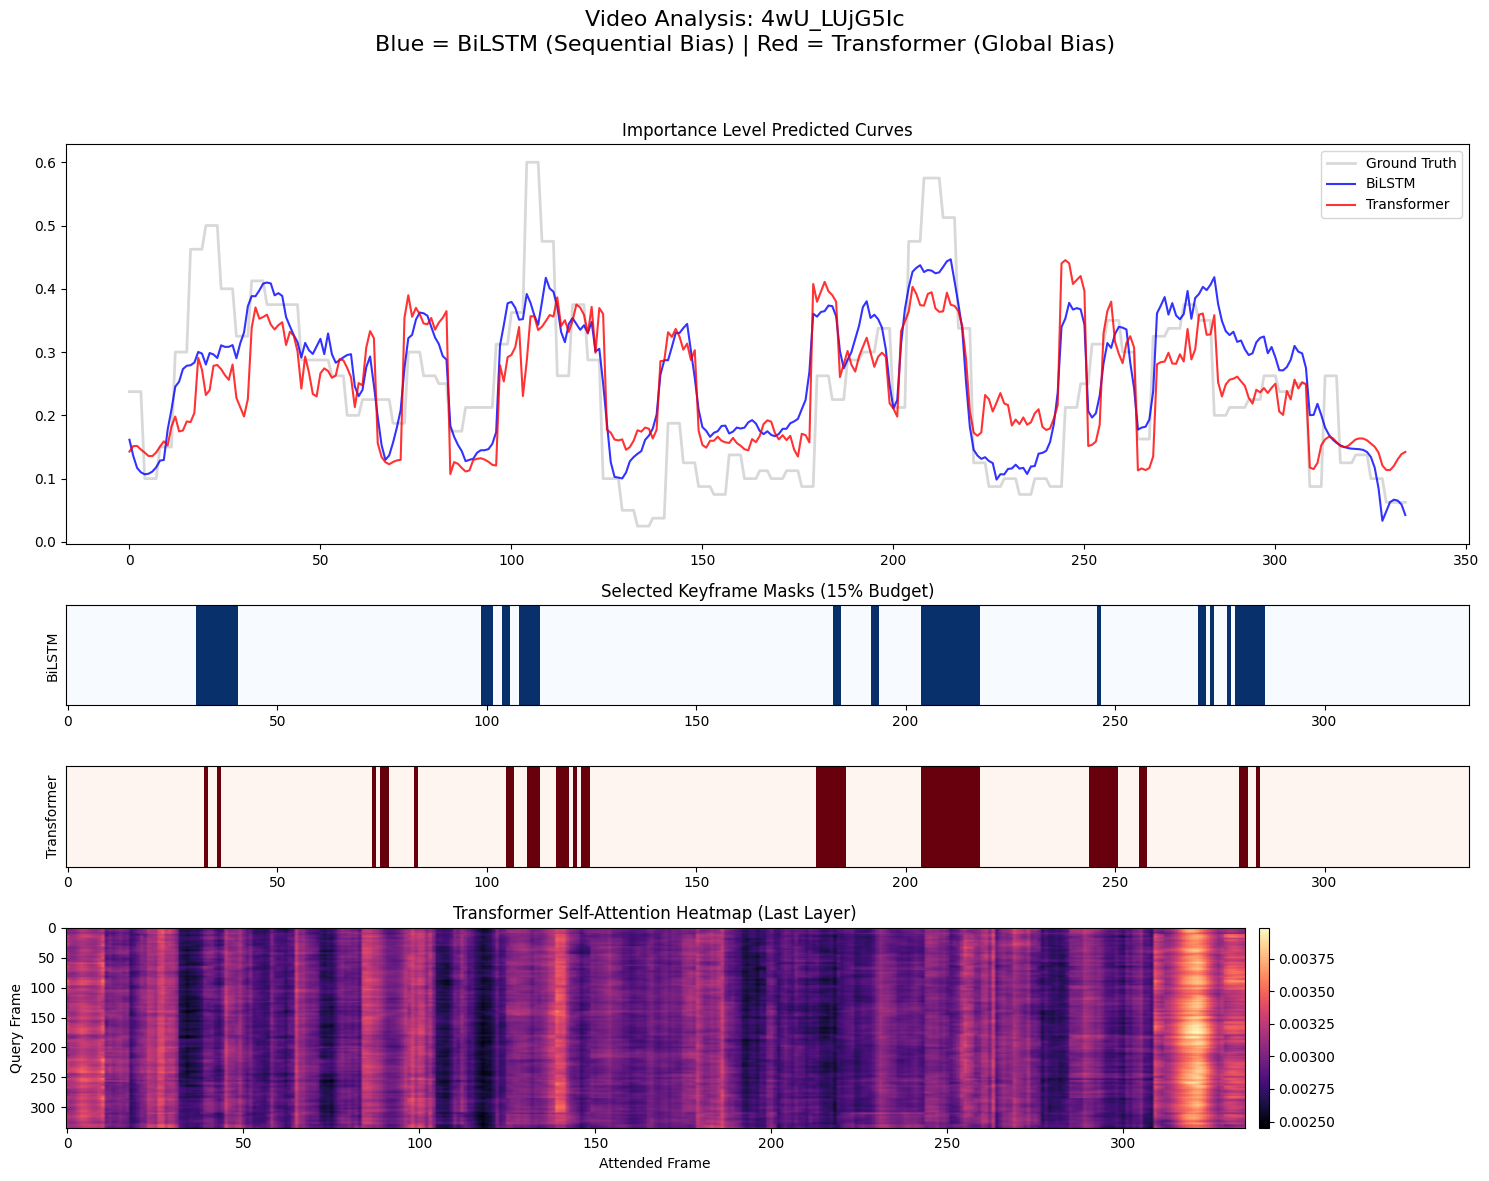

Saved qualitative plot to: /kaggle/working/4wU_LUjG5Ic_qualitative.png


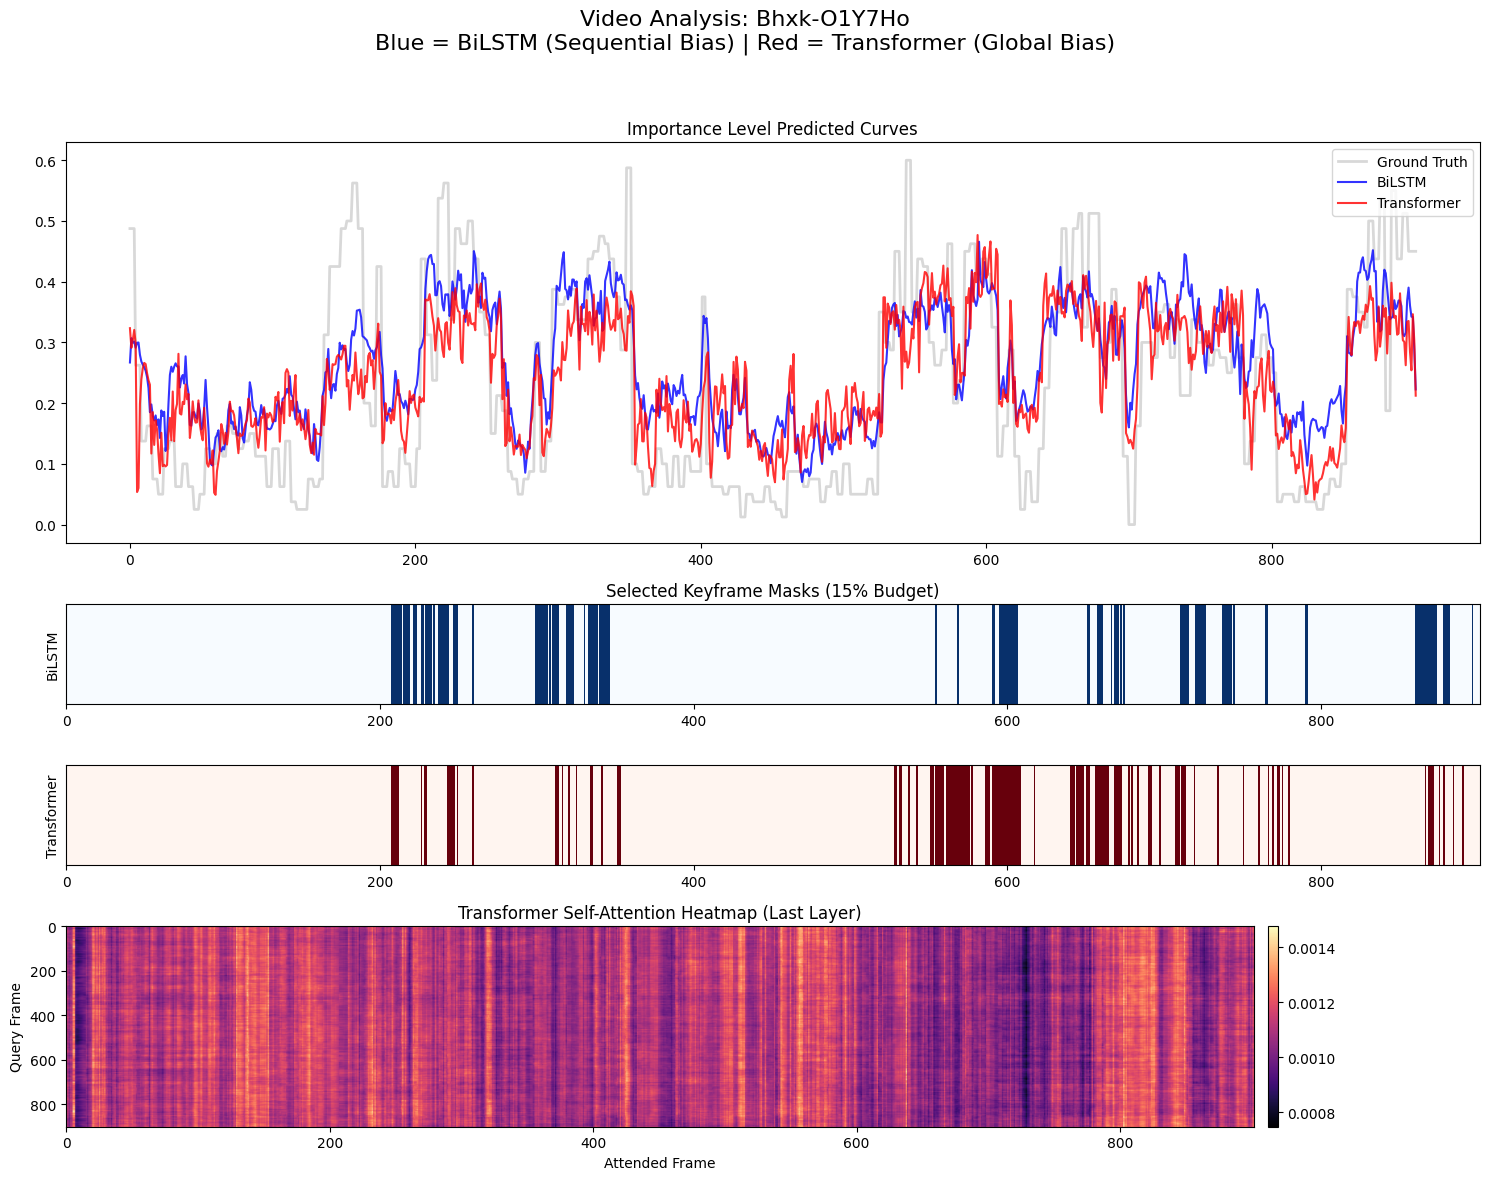

Saved qualitative plot to: /kaggle/working/Bhxk-O1Y7Ho_qualitative.png


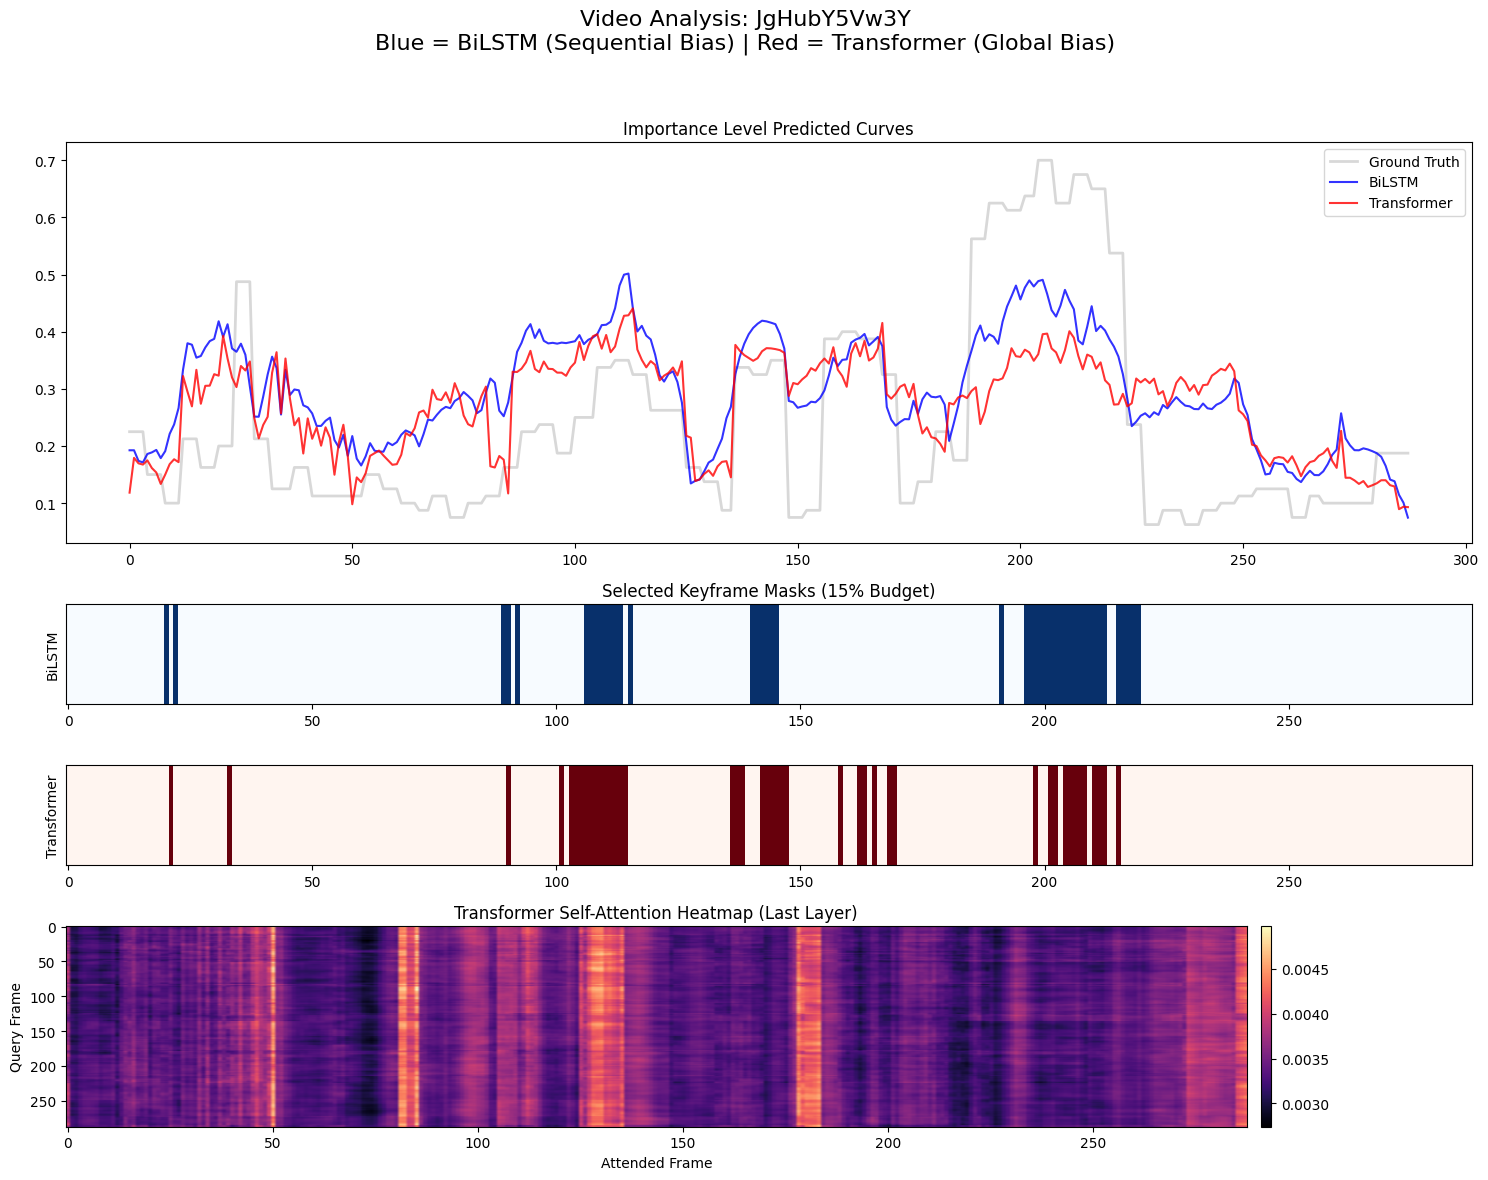

Saved qualitative plot to: /kaggle/working/JgHubY5Vw3Y_qualitative.png


In [11]:
for vid_id in val_ids[:3]:
    visualize_summary(vid_id)

## 6. Discussion of Observations

From the generated plots, we can typically observe:
- **Inductive Bias Check**: The BiLSTM (Blue) often produces smoother, contiguous blocks of selection because it models temporal flow. The Transformer (Red) may select more disjointed but thematically consistent frames due to its global attention.
- **Attention Alignment**: High-importance spikes in the Ground Truth often correspond to dense vertical lines in the attention heatmap, indicating that many query frames are "attending" to those specific key events.
- **Error Modes**: Discrepancies between the predicted masks and GT are saved to disk for further error analysis in subsequent notebooks.